In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

In [3]:
# for data processing
import os, sys
module_path = os.path.join('/home/ckaul/DriesNotebook')
if module_path not in sys.path:
    sys.path.append(module_path)
from mmctools.dataloaders import read_files
from mmctools.helper_functions import calc_wind, theta, covariance

/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [4]:
# site-specific correction
from TTURawToMMC import reg_coefs, tilts
from mmctools.measurements.metmast import tilt_correction

In [5]:
# for plotting
from mmctools.plotting import plot_timehistory_at_height, plot_profile

# Process and tilt-correct sonic data from TTU tower
written by [Eliot Quon](mailto:eliot.quon@nrel.gov)

Process data at SWiFT on 2013-11-08 and 09

In [6]:
# DAP data
dataset = '/projects/mmcpnnl/ckaul/mmc_tower'
datapath = '/projects/mmcpnnl/ckaul/mmc_tower/ProcessedData' # where the data will get saved locally
startdate = pd.to_datetime('2013-11-08')
enddate = pd.to_datetime('2013-11-10')

In [7]:
# outputs
output_1Hz = '/projects/mmcpnnl/ckaul/mmc_tower/ProcessedData/TTU_tilt_corrected_20131108-09.csv'
output_10min = '/projects/mmcpnnl/ckaul/mmc_tower/ProcessedData/TTU_tilt_corrected_20131108-09_10min.csv'

## 1. Data processing

In [8]:
filelist = []
overwrite_files = False # force download of files

### 1a. try to get data from DAP on the fly

In [9]:
try:
    import A2e
except ImportError:
    print('dap-py module not available; need to manually set `filelist`')
else:
    a2e = A2e.A2e()
    a2e.setup_cert_auth()
    datafiles = a2e.search({
        'Dataset': dataset,
        'date_time': {
            'between': [startdate.strftime('%Y%m%d%H%M%S'), enddate.strftime('%Y%m%d%H%M%S')]
        }
    })
    print(len(datafiles),'data files selected')
    filelist = a2e.download_files(datafiles, path=datapath, force=overwrite_files)
    if filelist is None:
        print('No files were downloaded; need to manually download and set `filelist`')

No authentication found. Using guest credentials...
username: quon
password: ········
Success!
48 data files selected
Could not place order
Server Returned Bad Status Code
Status Code: 400
Reason: order is too large to create (10 GB limit)
No files were downloaded; need to manually download and set `filelist`


In [8]:
# UNCOMMENT THIS to use previously downloaded files
import glob
filelist = glob.glob('/projects/mmcpnnl/ckaul/mmc_tower/*.dat')
filelist.sort()
filelist

['/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.000000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.010000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.020000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.030000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.040000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.050000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.060000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.070000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.080000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.090000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.100000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.20131108.110000.ttu200m.dat',
 '/projects/mmcpnnl/ckaul/mmc_tower/tower.z01.00.201

### 1b. process downloaded data

In [9]:
variables = ['unorth','vwest','w','ustream','vcross','wdir','tsonic','t','p','rh']

#heights_ft = [3,8,13,33,55,155,245,382,519,656]
heights = np.array([0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0])
sampling_freq = 50. # Hz
resample_interval = '1s'

In [10]:
# *wide* format: variables change the fastest, then heights
# e.g., unorth_3ft, vwest_3ft, ..., rh_3ft, unorth_8ft, vwest_8ft, ...
columns = pd.MultiIndex.from_product([heights,variables],names=['height',None])

In [11]:
def read_wide_csv(fname,**kwargs):
    """Convert table in wide format into stacked/long format with multi-index"""
    df = pd.read_csv(fname,
                     skiprows=5, header=None,
                     index_col=0, parse_dates=True,
                     **kwargs)
    df.index.name = 'datetime'
    df.columns = columns
    df = df.resample(resample_interval).first()
    return df.stack(level=0)

In [12]:
%time rawdata = read_files(filelist, reader=read_wide_csv)
rawdata.head()
# CPU times: user 2min 16s, sys: 10.3 s, total: 2min 26s
# Wall time: 2min 27s

CPU times: user 7min 1s, sys: 13.2 s, total: 7min 14s
Wall time: 1min 56s


p      rh        t    tsonic    unorth   ustream  \
datetime   height                                                             
2013-11-08 0.9     90.854775  26.186  52.9592  61.26800 -2.638194  2.640161   
           2.4     90.872351  25.810  53.2076  64.09399 -2.796803  2.833327   
           4.0     90.821555  25.380  53.6288  57.86600 -4.041865  4.005252   
           10.1    90.761141  25.264  53.8664  57.38000 -5.229591  5.225090   
           16.8    90.730765  24.934  54.0752  58.02800 -5.908238  5.901349   

                     vcross     vwest         w        wdir  
datetime   height                                            
2013-11-08 0.9    -0.093404 -0.138231  0.040203  177.000664  
           2.4     0.393956 -0.600695  0.297950  167.878211  
           4.0    -0.683208  0.414897  0.342024  185.860873  
           10.1   -0.351743 -0.276876 -0.354408  176.969358  
           16.8   -0.287311  0.034531 -0.112876  180.334863

### 1c. data standardization
<font color='red'>These data conversions are specific to TTU met tower (tower.z01.00)</font>

In [13]:
rawdata['u'] = rawdata['vwest']
rawdata['v'] = -rawdata['unorth']

In [14]:
# convert from deg F to K
rawdata['t'] = 5./9. * (rawdata['t']-32) + 273.15
rawdata['tsonic'] = 5./9. * (rawdata['tsonic']-32) + 273.15

In [15]:
# convert kPa to mbar
rawdata['p'] *= 10.

In [16]:
# rename vars
rawdata = rawdata.rename(columns={
    't': 'T',
    'tsonic': 'Ts',
    'rh': 'RH',
})

## 2. Calculations
### 2a. Perform tilt correction

In [17]:
corrected = rawdata[['u','v','w','Ts','T','RH','p']].unstack() # make an unstacked copy

In [18]:
ucorr,vcorr,wcorr = tilt_correction(corrected['u'],corrected['v'],corrected['w'],
                                    reg_coefs=reg_coefs,
                                    tilts=tilts)

In [19]:
corrected.loc[:,'u'] = ucorr
corrected.loc[:,'v'] = vcorr
corrected.loc[:,'w'] = wcorr

In [20]:
corrected = corrected.stack(dropna=False)

<font color='green'>At this point, we save the high-frequency data for spectral analysis</font>

In [21]:
%time corrected.to_csv(output_1Hz)
# CPU times: user 32.7 s, sys: 1.33 s, total: 34 s
# Wall time: 34.1 s

CPU times: user 28.1 s, sys: 422 ms, total: 28.6 s
Wall time: 28.6 s


### 2b. Calculate additional quantities of interest
Note: per `TTU_tower_heatflux_stability.ipynb`, `theta` (calculated from air temperature) is acceptable for analysis in the mean; for correlations, `thetas` (calculated from sonic temperature) should be used for calculating fluctuations and correlations. 

In [22]:
def calc_QOIs(df):
    df['theta'] = theta(df['T'], df['p'])
    df['thetas'] = theta(df['Ts'], df['p'])

In [23]:
calc_QOIs(rawdata)
rawdata.head()

p      RH        T          Ts    unorth  \
datetime   height                                                      
2013-11-08 0.9     908.547754  26.186  284.794  289.410000 -2.638194   
           2.4     908.723508  25.810  284.932  290.979994 -2.796803   
           4.0     908.215548  25.380  285.166  287.520000 -4.041865   
           10.1    907.611414  25.264  285.298  287.250000 -5.229591   
           16.8    907.307654  24.934  285.414  287.610000 -5.908238   

                    ustream    vcross     vwest         w        wdir  \
datetime   height                                                       
2013-11-08 0.9     2.640161 -0.093404 -0.138231  0.040203  177.000664   
           2.4     2.833327  0.393956 -0.600695  0.297950  167.878211   
           4.0     4.005252 -0.683208  0.414897  0.342024  185.860873   
           10.1    5.225090 -0.351743 -0.276876 -0.354408  176.969358   
           16.8    5.901349 -0.287311  0.034531 -0.112876  180.334863   

                          u         v       theta      thetas  
datetime   height                                              
2013-11-08 0.9    -0.138231  2.638194  292.713920  297.458288  
           2.4    -0.600695  2.796803  292.839558  299.055399  
           4.0     0.414897  4.041865  293.126923  295.546639  
           10.1   -0.276876  5.229591  293.318423  295.325299  
           16.8    0.034531  5.908238  293.465778  295.723729

In [24]:
calc_QOIs(corrected)
corrected.head()

u         v         w          Ts        T      RH  \
datetime   height                                                              
2013-11-08 0.9    -0.138929  2.637817  0.074016  289.410000  284.794  26.186   
           2.4    -0.601111  2.783204  0.487330  290.979994  284.932  25.810   
           4.0     0.416792  4.043940  0.295800  287.520000  285.166  25.380   
           10.1   -0.276479  5.227110 -0.418065  287.250000  285.298  25.264   
           16.8    0.034364  5.908367 -0.173836  287.610000  285.414  24.934   

                            p       theta      thetas  
datetime   height                                      
2013-11-08 0.9     908.547754  292.713920  297.458288  
           2.4     908.723508  292.839558  299.055399  
           4.0     908.215548  293.126923  295.546639  
           10.1    907.611414  293.318423  295.325299  
           16.8    907.307654  293.465778  295.723729

### 2c. Calculate rolling statistics
See `TTU_tower_heatflux_stability.ipynb` for more details regarding $T_v$ vs $T_s$

In [25]:
def calc_rolling_stats(df,offset='10min'):
    """Calculate quantities of interest, with statistics based on the specified pandas offset string
    
    Note: we could also have used `resample` instead of `rolling`. To be consistent with previous analyses,
    however, I've used rolling statistics for the plots in the next section.
    """
    # calculate statistical quantities on unstacked 
    unstacked = df.unstack()
    stats = unstacked.rolling(offset).mean().stack()
    # - recalculate wind based on averaged components
    stats['wspd'], stats['wdir'] = calc_wind(stats)
#     stats['theta'] = theta(stats['T'], stats['p'])
#     stats['thetas'] = theta(stats['Ts'], stats['p'])
    # - calculate variances
    stats['uu'] = unstacked['u'].rolling(offset).var().stack()
    stats['vv'] = unstacked['v'].rolling(offset).var().stack()
    stats['ww'] = unstacked['w'].rolling(offset).var().stack()
    # - calculate covariances
    stats['uv'] = covariance(unstacked['u'], unstacked['v'], offset).stack()
    stats['vw'] = covariance(unstacked['v'], unstacked['w'], offset).stack()
    stats['uw'] = covariance(unstacked['u'], unstacked['w'], offset).stack()
    stats['Tw'] = covariance(unstacked['Ts'], unstacked['w'], offset).stack()
    stats['thetaw'] = covariance(unstacked['thetas'], unstacked['w'], offset).stack()
    # - calculate derived quantities
    #   TODO: implement in helper_functions.py
    stats['u*'] = (stats['uw']**2 + stats['vw']**2)**0.25
    stats['TKE'] = 0.5*(stats['uu'] + stats['vv'] + stats['ww'])
    ang = np.radians(270. - stats['wdir'])
    ang[ang<0] += 2*np.pi
    stats['TI'] = stats['uu']*np.cos(ang)**2 + 2*stats['uv']*np.sin(ang)*np.cos(ang) + stats['vv']*np.sin(ang)**2
    stats['TI'] = np.sqrt(stats['TI']) / stats['wspd']
    return stats

In [26]:
%time uncorrected_10min = calc_rolling_stats(rawdata)
# CPU times: user 24.2 s, sys: 2.03 s, total: 26.2 s
# Wall time: 24.9 s

CPU times: user 2min 2s, sys: 3.44 s, total: 2min 6s
Wall time: 20.6 s


In [27]:
# rolling 10-min stats
%time corrected_10min = calc_rolling_stats(corrected)
# CPU times: user 22.3 s, sys: 1.48 s, total: 23.8 s
# Wall time: 23 s

CPU times: user 1min 58s, sys: 3.32 s, total: 2min 2s
Wall time: 20 s


<font color='green'>We can now save more general (and manageable) validation data for other analyses</font>

In [28]:
# save resampled 10-min stats (note: we've already calculated the rolling statistics)
corrected_10min.unstack().resample('10min').first().stack().to_csv(output_10min)

## 3. Plots

In [29]:
times = corrected_10min.index.levels[0]
times

DatetimeIndex(['2013-11-08 00:00:00', '2013-11-08 00:00:01',
               '2013-11-08 00:00:02', '2013-11-08 00:00:03',
               '2013-11-08 00:00:04', '2013-11-08 00:00:05',
               '2013-11-08 00:00:06', '2013-11-08 00:00:07',
               '2013-11-08 00:00:08', '2013-11-08 00:00:09',
               ...
               '2013-11-09 23:59:50', '2013-11-09 23:59:51',
               '2013-11-09 23:59:52', '2013-11-09 23:59:53',
               '2013-11-09 23:59:54', '2013-11-09 23:59:55',
               '2013-11-09 23:59:56', '2013-11-09 23:59:57',
               '2013-11-09 23:59:58', '2013-11-09 23:59:59'],
              dtype='datetime64[ns]', name='datetime', length=172798, freq=None)

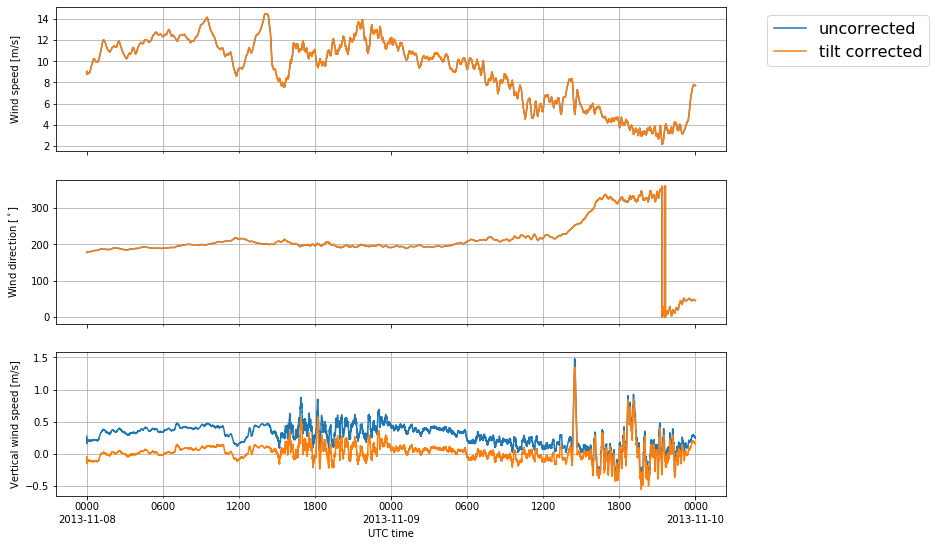

In [30]:
zhub = 74.7
fig,ax = plot_timehistory_at_height(
    {'uncorrected':uncorrected_10min, 'tilt corrected':corrected_10min},
    fields=['wspd','wdir','w'],
    heights=zhub,
)

IndexError: tuple index out of range

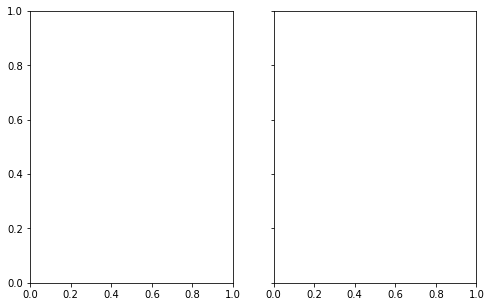

In [33]:
selected_times = [
    '2013-11-08 12:00:00', # very stable
    '2013-11-08 15:00:00', # ~neutral
    '2013-11-08 18:00:00', # slightly unstable
    '2013-11-08 21:00:00', # ~neutral
    '2013-11-09 00:00:00', # ~neutral
    '2013-11-09 03:00:00', # slightly stable
]
fig,ax = plot_profile(corrected_10min, fields=['Ts','theta'], times=selected_times, cmap='viridis')
# ax[0].set_xlabel(r'$T_s$ [K]')
# ax[1].set_xlabel(r'$\theta$ [K]')

Text(0.5, 0, '$time$ $[\\mathrm{HH:MM}]$ $Z$')

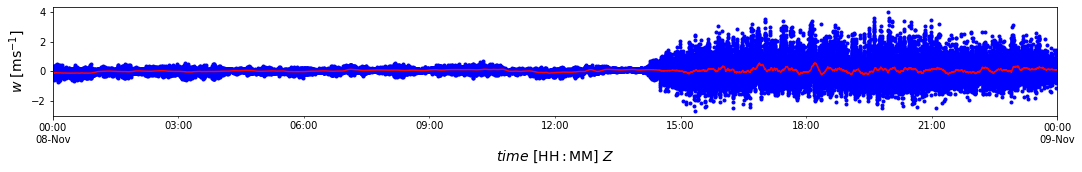

In [32]:
# Jeremy's plot from `TTU_tiltCorrection.ipynb`
w = corrected.xs(zhub, level='height')['w']
day1 = (w.index >= '2013-11-08 00:00') & (w.index <= '2013-11-09 00:00')
w = w.loc[day1]
wmean = w.rolling('10min').mean()
fig,ax = plt.subplots(figsize=(18,2))
w.plot(style='b.')
wmean.plot(style='r-')
ax.set_ylabel(r'$w$ $[\mathrm{ms^{-1}}]$', fontsize=14)
ax.set_xlabel(r'$time$ $[\mathrm{HH:MM}]$ $Z$', fontsize=14)